Regression Test RMSE: 17.696
Regression model saved as 'random_forest_regressor_best.pkl'
Classification Accuracy: 0.9994

Classification Report:
                         precision    recall  f1-score   support

OK - No watering needed       1.00      1.00      1.00       393
        Sensor Unstable       1.00      1.00      1.00       386
   Soil Dry - Water now       1.00      1.00      1.00       400
             Soil Moist       1.00      1.00      1.00       418

               accuracy                           1.00      1597
              macro avg       1.00      1.00      1.00      1597
           weighted avg       1.00      1.00      1.00      1597



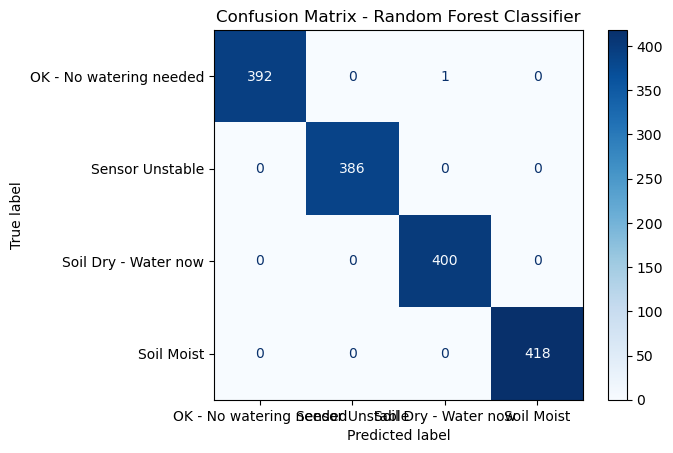

Classifier model saved as 'random_forest_classifier_best.pkl'


In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import matplotlib.pyplot as plt
import joblib

# Load dataset
df = pd.read_csv('soil_moisture_balanced_classification_6h.csv', parse_dates=['timestamp'])

# Prepare features for regression
# Drop target + non-feature columns for regression
reg_drop_cols = ['moisture', 'recommendation', 'timestamp', 'moisture_future_6h']
reg_feature_cols = [col for col in df.columns if col not in reg_drop_cols]

X_reg = df[reg_feature_cols]
y_reg = df['moisture']  # regression target

# Clean NaNs for regression
df_reg_clean = df.dropna(subset=['moisture'])
df_reg_clean = df_reg_clean.dropna(subset=reg_feature_cols)
X_reg = df_reg_clean[reg_feature_cols]
y_reg = df_reg_clean['moisture']

# Regression train/test split
X_reg_train, X_reg_test, y_reg_train, y_reg_test = train_test_split(
    X_reg, y_reg, test_size=0.2, random_state=42, shuffle=True
)

# Train Random Forest Regression
rf_reg = RandomForestRegressor(
    bootstrap=True,
    max_depth=None,
    min_samples_leaf=2,
    min_samples_split=10,
    n_estimators=300,
    random_state=42,
    n_jobs=-1
)
rf_reg.fit(X_reg_train, y_reg_train)

# Predict regression test set
y_reg_pred = rf_reg.predict(X_reg_test)
rmse = np.sqrt(mean_squared_error(y_reg_test, y_reg_pred))
print(f"Regression Test RMSE: {rmse:.3f}")

# Save regression model
joblib.dump(rf_reg, "random_forest_regressor_best.pkl")
print("Regression model saved as 'random_forest_regressor_best.pkl'")

# ----------------------------------------
# Prepare features for classification
# Include predicted moisture from regression for classification input

# Use samples from regression train set (to avoid data leakage)
X_clf = X_reg_train.copy()
X_clf['predicted_moisture'] = rf_reg.predict(X_reg_train)

# Classification target
y_clf = df_reg_clean.loc[X_clf.index, 'recommendation']

# Clean NaNs for classification
clf_drop_cols = []  # no extra drops needed as handled above
X_clf = X_clf.dropna()
y_clf = y_clf.loc[X_clf.index]

# Classification train/test split
X_clf_train, X_clf_test, y_clf_train, y_clf_test = train_test_split(
    X_clf, y_clf, test_size=0.25, random_state=42, shuffle=True
)

# Train Random Forest Classifier
rf_clf = RandomForestClassifier(
    bootstrap=False,
    max_depth=None,
    max_features='sqrt',
    min_samples_leaf=4,
    min_samples_split=10,
    n_estimators=100,
    random_state=42,
    n_jobs=-1
)
rf_clf.fit(X_clf_train, y_clf_train)

# Predict classification on test set
y_clf_pred = rf_clf.predict(X_clf_test)

# Accuracy and report
acc = accuracy_score(y_clf_test, y_clf_pred)
print(f"Classification Accuracy: {acc:.4f}")
print("\nClassification Report:")
print(classification_report(y_clf_test, y_clf_pred))

# Confusion matrix plot
cm = confusion_matrix(y_clf_test, y_clf_pred, labels=rf_clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf_clf.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Random Forest Classifier")
plt.show()

# Save classification model
joblib.dump(rf_clf, "random_forest_classifier_best.pkl")
print("Classifier model saved as 'random_forest_classifier_best.pkl'")


In [ ]:
import pandas as pd
import numpy as np
import joblib

# Load new test dataset with basic columns only: timestamp, temperature, humidity, moisture
test_df = pd.read_csv('realistic_soil_moisture_scenario.csv', parse_dates=['timestamp'])

# ----------------------------
# Generate lag and rolling features (same as training)
# ----------------------------

N_LAGS = 6  # number of lag steps
FORECAST_HOURS = 6
INTERVAL_MINUTES = 30  # assuming frequency

for lag in range(1, N_LAGS + 1):
    test_df[f'moisture_lag_{lag}'] = test_df['moisture'].shift(lag)
    test_df[f'temperature_lag_{lag}'] = test_df['temperature'].shift(lag)
    test_df[f'humidity_lag_{lag}'] = test_df['humidity'].shift(lag)

test_df['moisture_ma_3'] = test_df['moisture'].rolling(window=3).mean()
test_df['moisture_var_3'] = test_df['moisture'].rolling(window=3).var()

# Create future moisture target for reference (not used for prediction)
steps_ahead = int((FORECAST_HOURS * 60) / INTERVAL_MINUTES)
test_df[f'moisture_future_{FORECAST_HOURS}h'] = test_df['moisture'].shift(-steps_ahead)

# Drop initial rows with NaNs caused by lagging
test_df = test_df.dropna().reset_index(drop=True)

# ----------------------------
# Load saved models
# ----------------------------
reg_model = joblib.load('random_forest_regressor_best.pkl')
clf_model = joblib.load('random_forest_classifier_best.pkl')

# ----------------------------
# Prepare regression features (exclude target, labels, timestamp)
# ----------------------------
reg_drop_cols = ['moisture', 'recommendation', 'timestamp', f'moisture_future_{FORECAST_HOURS}h']
reg_drop_cols = [col for col in reg_drop_cols if col in test_df.columns]
reg_feature_cols = [col for col in test_df.columns if col not in reg_drop_cols]

X_reg_test = test_df[reg_feature_cols]

# ----------------------------
# Predict soil moisture (regression)
# ----------------------------
regression_preds = reg_model.predict(X_reg_test)

# ----------------------------
# Prepare classification input by adding predicted moisture
# ----------------------------
X_clf_test = X_reg_test.copy()
X_clf_test['predicted_moisture'] = regression_preds

# ----------------------------
# Predict recommendation (classification)
# ----------------------------
clf_preds = clf_model.predict(X_clf_test)

# ----------------------------
# Output results
# ----------------------------
results = test_df[['timestamp', 'moisture', 'temperature', 'humidity']].copy()
results['predicted_moisture'] = regression_preds
results['predicted_recommendation'] = clf_preds

print(results.head(10))

# Save to CSV
results.to_csv('test_predictions_recommendations.csv', index=False)
print("Predictions & recommendations saved to 'test_predictions_recommendations.csv'")
